First, we'll grab the JSON data of celebrity deaths from USA Today:

In [1]:
import pandas as pd 

celebrities_df = pd.read_csv('celebrity_deaths.csv', names=['name', 'birthdate', 'deathdate'], header=0)
celebrities_df['birthdate'] = pd.to_datetime(celebrities_df['birthdate'])
celebrities_df['deathdate'] = pd.to_datetime(celebrities_df['deathdate'])

# For the purposes of our analysis, we're only interested in deaths in 2022 and later
celebrities_df = celebrities_df[celebrities_df['deathdate'] >= '2022-01-01']

celebrities_df = celebrities_df.sort_values('deathdate').reset_index(drop = True)
celebrities_df

,name,birthdate,deathdate
0,Dan Reeves,1944-01-19,2022-01-01
1,Sidney Poitier,1927-02-20,2022-01-06
2,Peter Bogdanovich,1939-07-30,2022-01-06
3,Bob Saget,1956-05-17,2022-01-09
4,Robert Durst,1943-04-12,2022-01-10
...,...,...,...
185,Suzanne Somers,1946-10-16,2023-10-15
186,Richard Roundtree,1942-07-09,2023-10-24
187,Matthew Perry,1969-08-19,2023-10-28
188,Frank Howard,1936-08-08,2023-10-30


# Now lets generate the actual prompt we'll give to ChatGPT

In [2]:
prompt = (
    "Given a list of celebrity names and their birth dates, generate a JSON object containing their death dates.\n" 
    "For example, given 'Michael Jackson (1958-08-28)', you would output: { \"Michael Jackson\": \"2009-06-25\" }\n" +
    "If the person is still alive, return a blank string for their death date.\n\n" +
    "Now, return a JSON object containing every celebrity in this list:\n\n" + 
    "\n".join(f"{index + 1}. {row.name} ({row.birthdate.strftime('%Y-%m-%d')})" for index, row in enumerate(celebrities_df.itertuples()))
)

print(prompt)

Given a list of celebrity names and their birth dates, generate a JSON object containing their death dates.
For example, given 'Michael Jackson (1958-08-28)', you would output: { "Michael Jackson": "2009-06-25" }
If the person is still alive, return a blank string for their death date.

Now, return a JSON object containing every celebrity in this list:

1. Dan Reeves (1944-01-19)
2. Sidney Poitier (1927-02-20)
3. Peter Bogdanovich (1939-07-30)
4. Bob Saget (1956-05-17)
5. Robert Durst (1943-04-12)
6. Don Maynard (1935-01-25)
7. Ronnie Spector (1943-08-10)
8. Peter Robbins (1956-08-10)
9. André Leon Talley (1948-10-16)
10. Meat Loaf (1947-09-27)
11. Louie Anderson (1953-03-24)
12. Moses J. Moseley (1991-12-24)
13. Howard Hesseman (1940-02-27)
14. Gerald Williams (1966-08-10)
15. Jeremy Giambi (1974-09-30)
16. Betty Davis (1945-07-26)
17. Ivan Reitman (1946-10-27)
18. Sally Kellerman (1937-06-02)
19. Ned Eisenberg (1957-01-13)
20. Alan Ladd, Jr. (1937-10-22)
21. Emilio Delgado (1940-05-0

Lets see what ChatGPT thinks...

In [3]:
import json
from openai import OpenAI

client = OpenAI()

results = []

# We're going to try this several times with different temperatures to 
# minimize the impact temperture and randomness might have on the results

temperatures = [0, 0.5, 1]
attempts_per_temperature = 3
for temperature in temperatures:
    for attempt in range(1, attempts_per_temperature + 1):
        print(f'Attempt #{attempt} for temperature {temperature}...')
        
        try:
            response = client.chat.completions.create(
                messages=[{
                    'role': 'user',
                    'content': prompt,
                }],
                model='gpt-4-1106-preview',
                temperature=temperature,
                response_format={ 'type': 'json_object' }
            )

            response_json = response.choices[0].message.content
            response_dict = json.loads(response_json)
            print(f'  Results: {len(response_dict)}')
            
            for name, gpt_deathdate in response_dict.items():
                results.append({
                    'temperature': temperature, 
                    'name': name, 
                    'gpt_deathdate': gpt_deathdate
                })
        except json.JSONDecodeError:
            print('  JSON parsing error; skipping')

gpt_results = pd.DataFrame(results, columns=['temperature', 'name', 'gpt_deathdate'])
gpt_results['gpt_deathdate'] = pd.to_datetime(gpt_results['gpt_deathdate'], errors='coerce')
gpt_results

Attempt #1 for temperature 0...
  Results: 190
Attempt #2 for temperature 0...
  Results: 190
Attempt #3 for temperature 0...
  Results: 190
Attempt #1 for temperature 0.5...
  Results: 190
Attempt #2 for temperature 0.5...
  Results: 190
Attempt #3 for temperature 0.5...
  Results: 190
Attempt #1 for temperature 1...
  Results: 190
Attempt #2 for temperature 1...
  Results: 93
Attempt #3 for temperature 1...
  Results: 190


,temperature,name,gpt_deathdate
0,0.0,Dan Reeves,2022-01-01
1,0.0,Sidney Poitier,2022-01-06
2,0.0,Peter Bogdanovich,2022-01-06
3,0.0,Bob Saget,2022-01-09
4,0.0,Robert Durst,2022-01-10
...,...,...,...
1608,1.0,Suzanne Somers,NaT
1609,1.0,Richard Roundtree,NaT
1610,1.0,Matthew Perry,NaT
1611,1.0,Frank Howard,NaT


Next, we'll merge the data frame with the actual deaths with the GPT results, and then filter it down to just the row that has the closest GPT death with the actual death.

In [4]:
merged_df = pd.merge(gpt_results, celebrities_df[['name', 'deathdate']], on='name', how='inner')

# We'll rename 'deathdate' to 'actual_deathdate' to make what it represents clear, since we now also have a `gpt_deathdate' column
merged_df = merged_df.rename(columns={'deathdate': 'actual_deathdate'})
merged_df['date_difference'] = (merged_df['gpt_deathdate'] - merged_df['actual_deathdate']).dt.days
merged_df['abs_date_difference'] = merged_df['date_difference'].abs()

# For now, we'll remove any that GPT didn't have a result for
cleaned_df = merged_df.dropna(subset=['name', 'abs_date_difference'])

# Group by name and select the row with the smallest absolute date difference for each name, 
# which will represent GPT's closest response to reality
def select_row_with_min_difference(group):
    return group.loc[group['abs_date_difference'].idxmin()]

# This represents how close the GPT results are to reality
smallest_diff_df = cleaned_df.groupby('name').apply(select_row_with_min_difference).reset_index(drop=True)

gpt_results_final = smallest_diff_df[['name', 'actual_deathdate', 'gpt_deathdate', 'abs_date_difference']]
gpt_results_final

,name,actual_deathdate,gpt_deathdate,abs_date_difference
0,Aaron Carter,2022-11-05,2022-11-05,0.0
1,Adam Rich,2023-01-07,2023-01-07,0.0
2,Adreian Payne,2022-05-09,2022-05-09,0.0
3,"Alan Ladd, Jr.",2022-03-02,2022-03-02,0.0
4,Alan White,2022-05-26,2022-05-26,0.0
...,...,...,...,...
135,Traci Braxton,2022-03-12,2022-03-12,0.0
136,Vin Scully,2022-08-02,2022-08-02,0.0
137,Vince Dooley,2022-10-28,2022-10-28,0.0
138,William Hurt,2022-03-13,2022-03-13,0.0


Now we'll create a data frame with every celebrity in the original list, along with a column representing whether GPT accurately responded with their death date:

In [35]:
celebrity_deaths_with_gpt_date = pd.merge(celebrities_df, gpt_results_final, on='name', how='left')
celebrity_deaths_with_gpt_date = celebrity_deaths_with_gpt_date[['name', 'deathdate', 'gpt_deathdate', 'abs_date_difference']]
celebrity_deaths_with_gpt_date = celebrity_deaths_with_gpt_date.rename(columns={'deathdate': 'actual_deathdate'})
celebrity_deaths_with_gpt_date['is_accurate'] = celebrity_deaths_with_gpt_date['abs_date_difference'].le(10)

celebrity_deaths_with_gpt_date.to_csv('celebrity_deaths_with_gpt_date.csv', index=False)

celebrity_deaths_with_gpt_date

,name,actual_deathdate,gpt_deathdate,abs_date_difference,is_accurate
0,Dan Reeves,2022-01-01,2022-01-01,0.0,True
1,Sidney Poitier,2022-01-06,2022-01-06,0.0,True
2,Peter Bogdanovich,2022-01-06,2022-01-06,0.0,True
3,Bob Saget,2022-01-09,2022-01-09,0.0,True
4,Robert Durst,2022-01-10,2022-01-10,0.0,True
...,...,...,...,...,...
185,Suzanne Somers,2023-10-15,NaT,NaN,False
186,Richard Roundtree,2023-10-24,NaT,NaN,False
187,Matthew Perry,2023-10-28,NaT,NaN,False
188,Frank Howard,2023-10-30,NaT,NaN,False


Here, for anyone curious, is a list of all the celebrities whose deaths GPT knew about:

In [6]:
celebrity_deaths_with_gpt_date[celebrity_deaths_with_gpt_date['is_accurate'] == True]

,name,actual_deathdate,gpt_deathdate,abs_date_difference,is_accurate
0,Dan Reeves,2022-01-01,2022-01-01,0.0,True
1,Sidney Poitier,2022-01-06,2022-01-06,0.0,True
2,Peter Bogdanovich,2022-01-06,2022-01-06,0.0,True
3,Bob Saget,2022-01-09,2022-01-09,0.0,True
4,Robert Durst,2022-01-10,2022-01-10,0.0,True
...,...,...,...,...,...
136,Bud Grant,2023-03-11,2023-03-11,0.0,True
137,Joe Pepitone,2023-03-13,2023-03-13,0.0,True
138,Bobby Caldwell,2023-03-14,2023-03-14,0.0,True
139,Lance Reddick,2023-03-17,2023-03-17,0.0,True


And here are celebrities whose deaths it did not know accurately prior to GPT-4 Turbo's knowledge cutoff date

In [7]:
inaccurate_df_before_cutoff = celebrity_deaths_with_gpt_date[(celebrity_deaths_with_gpt_date['is_accurate'] == False) & (celebrity_deaths_with_gpt_date["actual_deathdate"] < '2023-04-01')]
inaccurate_df_before_cutoff.sort_values('actual_deathdate')

,name,actual_deathdate,gpt_deathdate,abs_date_difference,is_accurate
107,"Stephen ""tWitch"" Boss",2022-12-13,NaT,NaN,False
112,Lola Chantrelle Mitchell,2023-01-01,NaT,NaN,False
117,Julian Sands,2023-01-13,NaT,NaN,False
126,Terry Holland,2023-02-02,2023-02-22,20.0,False
141,Ryuichi Sakamoto,2023-03-28,NaT,NaN,False


In [8]:
celebrity_deaths_with_gpt_date['actual_deathdate'] = pd.to_datetime(celebrity_deaths_with_gpt_date['actual_deathdate'])
celebrity_deaths_with_gpt_date['year_month'] = celebrity_deaths_with_gpt_date['actual_deathdate'].dt.strftime('%Y-%m')
celebrity_deaths_with_gpt_date['year_month_formatted'] = celebrity_deaths_with_gpt_date['actual_deathdate'].dt.strftime('%b %Y')

result_df = celebrity_deaths_with_gpt_date.groupby('year_month').agg(
    total_count=('name', 'count'),
    accurate_count=('is_accurate', 'sum')
).reset_index()

accuracy_by_year_month = celebrity_deaths_with_gpt_date.groupby('year_month').apply(
    lambda x: pd.Series({
        'celebrity_count': len(x),
        'accurate_count': x['is_accurate'].sum(),
        'accuracy_percent': (x['is_accurate'].sum() / len(x)) * 100
    })
).reset_index()

# Merge 'year_month_formatted' for plotting
accuracy_by_year_month = accuracy_by_year_month.merge(
    celebrity_deaths_with_gpt_date[['year_month', 'year_month_formatted']].drop_duplicates(),
    on='year_month'
)

accuracy_by_year_month

,year_month,celebrity_count,accurate_count,accuracy_percent,year_month_formatted
0,2022-01,13.0,13.0,100.000000,Jan 2022
1,2022-02,6.0,6.0,100.000000,Feb 2022
2,2022-03,7.0,7.0,100.000000,Mar 2022
3,2022-04,16.0,16.0,100.000000,Apr 2022
4,2022-05,10.0,10.0,100.000000,May 2022
5,2022-06,8.0,8.0,100.000000,Jun 2022
6,2022-07,10.0,10.0,100.000000,Jul 2022
7,2022-08,7.0,7.0,100.000000,Aug 2022
8,2022-09,6.0,6.0,100.000000,Sep 2022
9,2022-10,8.0,8.0,100.000000,Oct 2022


Now lets visualize it:

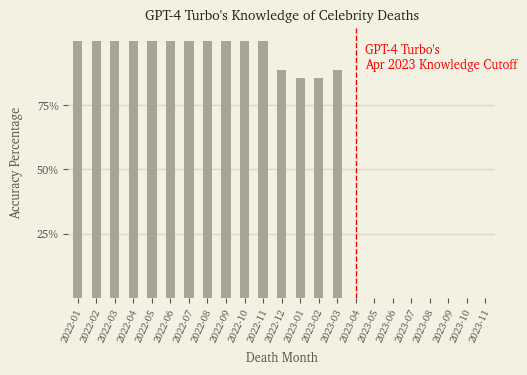

In [36]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.dates import DateFormatter
import matplotlib.transforms as transforms

matplotlib.rcParams['font.family'] = 'Charter'

plt.style.use('ggplot')

fig, ax = plt.subplots()
ax.set_facecolor('#f3f1e2')
ax.set_yticks([25, 50, 75])
ax.set_yticklabels(['25%', '50%', '75%'])
ax.yaxis.grid(True, color='#DAD8C9', linestyle='-', linewidth=1)

accuracy_by_year_month.plot(kind='bar', ax=ax, x='year_month', y='accuracy_percent', figsize=(5.5, 3.5), color='#A7A596', zorder=2, legend=False)

ax.grid(color='#f3f1e2', axis='x', linestyle='-', linewidth=2)
plt.gcf().set_facecolor('#f3f1e2')  # This should match the figure's facecolor

plt.title("GPT-4 Turbo's Knowledge of Celebrity Deaths", fontsize=10, color='#272516')
plt.xlabel('Death Month', fontsize=9, color='#5A5849', labelpad=6)
plt.ylabel('Accuracy Percentage', fontsize=9, color='#5A5849', labelpad=10)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(rotation=65, fontsize=7)
plt.yticks(fontsize=8)

offset = transforms.ScaledTranslation(-4/72, 0, plt.gcf().dpi_scale_trans)

for label in plt.gca().get_xticklabels():
    label.set_transform(label.get_transform() + offset)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Indicate its knowledge cutoff
bar_index = accuracy_by_year_month[accuracy_by_year_month['year_month'] == '2023-04'].index[0]
ax.axvline(x=bar_index, color='red', linewidth=1, zorder=1, linestyle='--')
bar_index = accuracy_by_year_month[accuracy_by_year_month['year_month'] == '2023-04'].index[0]
ax.text(bar_index + 0.5, plt.gca().get_ylim()[1] * 0.85, "GPT-4 Turbo's\nApr 2023 Knowledge Cutoff", color='red', ha='left', fontsize=9)

plt.savefig('accuracy_chart.png', bbox_inches='tight')

plt.show()